# Install and import libraries

## install necessry libraries

In [ ]:
#Import libraries of specific verision if not available 
!pip install -q tensorflow==2.3.0
!pip install -q kaggle

## import necessary libraries

In [1]:
#Import necessary libraries
import os
import cv2 
import pathlib
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import tensorflow_hub as hub

from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

# Load and unzip data from Kaggle

## uploading kaggle.json , creating kaggle directory and giving permissions

In [4]:
#Link to learn ho to get files from kaggle to colab - https://www.kaggle.com/general/74235
os.chdir("/content")
os.getcwd()
#Upload the Kaggel API token
from google.colab import files
files.upload()
! mkdir /.kaggle
! cp kaggle.json ~/.kaggle/
#Make directory named kaggle and copy kaggle.json file there.
! chmod 600 ~/.kaggle/kaggle.json
#change the directory


mkdir: cannot create directory ‘/.kaggle’: File exists


##loading and unzipping the data

In [5]:
#Load and unzip the data
!kaggle datasets download -d abhishek4273/helmet-dataset -p "/content"
!unzip helmet-dataset.zip -d train

 99% 642M/645M [00:27<00:00, 16.9MB/s]
100% 645M/645M [00:27<00:00, 24.8MB/s]
Archive:  helmet-dataset.zip
  inflating: train/helmet_dataset/JPEGImages/00000.jpg  
  inflating: train/helmet_dataset/JPEGImages/00001.jpg  
  inflating: train/helmet_dataset/JPEGImages/00002.jpg  
  inflating: train/helmet_dataset/JPEGImages/00003.jpg  
  inflating: train/helmet_dataset/JPEGImages/00004.jpg  
  inflating: train/helmet_dataset/JPEGImages/00005.jpg  
  inflating: train/helmet_dataset/JPEGImages/00006.jpg  
  inflating: train/helmet_dataset/JPEGImages/00007.jpg  
  inflating: train/helmet_dataset/JPEGImages/00008.jpg  
  inflating: train/helmet_dataset/JPEGImages/00009.jpg  
  inflating: train/helmet_dataset/JPEGImages/00010.jpg  
  inflating: train/helmet_dataset/JPEGImages/00011.jpg  
  inflating: train/helmet_dataset/JPEGImages/00012.jpg  
  inflating: train/helmet_dataset/JPEGImages/00013.jpg  
  inflating: train/helmet_dataset/JPEGImages/00014.jpg  
  inflating: train/helmet_dataset/JPEG

# Make changes in the Target csv file

In [6]:
target = pd.read_csv("/content/train/helmet_dataset/train_labels.csv")

In [7]:
print(target.head())
print(target.shape)

          ID                                              Label
0  01319.jpg  101 185 127 225 white 123 178 164 225 white 18...
1  00797.jpg  148 92 175 124 red 196 109 218 138 none 273 11...
2  00892.jpg  355 241 421 323 red 495 245 575 347 red 568 21...
3  00537.jpg  350 22 449 158 red 252 31 339 137 red 42 45 20...
4  01122.jpg                                92 71 194 179 blue 
(3174, 2)


In [8]:
#make the target dataframe more readable
labels= target['Label'].str.split(" ",expand=True)

In [9]:
print(labels.head())
print(labels.shape)

  0    1    2    3      4    5     ...  2099  2100  2101  2102  2103  2104
0  101  185  127  225  white  123  ...  None  None  None  None  None  None
1  148   92  175  124    red  196  ...  None  None  None  None  None  None
2  355  241  421  323    red  495  ...  None  None  None  None  None  None
3  350   22  449  158    red  252  ...  None  None  None  None  None  None
4   92   71  194  179   blue       ...  None  None  None  None  None  None

[5 rows x 2105 columns]
(3174, 2105)


In [10]:
target.drop(['Label'], axis=1,inplace=True)
target = pd.concat([target, labels],axis=1)
print(target.tail())
print(target.shape)

             ID    0     1     2     3  ...  2100  2101  2102  2103  2104
3169  00482.jpg   37   150    70   180  ...  None  None  None  None  None
3170  00762.jpg  942  1149  1069  1292  ...  None  None  None  None  None
3171  01126.jpg  196   150   234   206  ...  None  None  None  None  None
3172   1511.jpg  133  1863   273  2030  ...  None  None  None  None  None
3173  02304.jpg  188   201   210   225  ...  None  None  None  None  None

[5 rows x 2106 columns]
(3174, 2106)


In [11]:
target.iloc[:10]

,ID,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104
0,01319.jpg,101,185,127,225,white,123,178,164,225,white,181,193,219,240,white,213,185,247,228,white,287,183,323,227,white,410,167,445,210,white,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,00797.jpg,148,92,175,124,red,196,109,218,138,none,273,115,295,146,none,251,94,273,123,none,206,88,228,115,none,402,94,428,126,white,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,00892.jpg,355,241,421,323,red,495,245,575,347,red,568,213,622,286,red,630,185,661,230,red,438,207,468,241,red,462,199,486,226,red,195,226,230,267,red,202,209,230,240,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,00537.jpg,350,22,449,158,red,252,31,339,137,red,42,45,207,225,red,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,01122.jpg,92,71,194,179,blue,,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,02793.jpg,137,245,201,326,none,272,281,287,300,none,345,268,398,338,none,404,275,447,326,none,535,222,605,314,none,598,232,654,309,none,726,256,806,349,none,947,216,1015,296,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,00948.jpg,192,129,227,168,red,265,123,295,160,red,288,104,329,159,red,372,82,420,144,red,431,111,462,152,red,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,02547.jpg,90,288,99,299,yellow,120,289,129,301,yellow,220,264,232,277,yellow,383,276,393,287,yellow,471,282,481,294,yellow,481,274,490,283,yellow,454,269,464,279,red,320,247,335,263,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,02872.jpg,154,129,318,314,yellow,633,60,793,253,white,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,02292.jpg,468,439,489,462,yellow,538,421,572,459,yellow,770,417,796,452,red,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

# Explore random image and and croppings 

In [12]:
def explore(img_name):
  img = plt.imread("/content/train/helmet_dataset/JPEGImages/"+img_name)
  crop_image = img[164:225,123:178] #image[imgdata.iloc[index+1]:imgdata.iloc[index+3],imgdata.iloc[index]:imgdata.iloc[index+2]]
  plt.figure(figsize=(10,10))
  plt.subplot(131)
  plt.imshow(crop_image)
  print(img.shape)
  plt.figure(figsize=(10,10))
  plt.subplot(121)
  plt.imshow(img)
  # bb = df['bbox'][df['file_name']==int(img_name[:-4])].values.tolist()[0].tolist()
  # cv2.rectangle(img,(bb[1],bb[0]),(bb[3],bb[2]),[255,0,0],2)
  # plt.subplot(122)
  # plt.imshow(img)
  #plt.show()

(397, 600, 3)


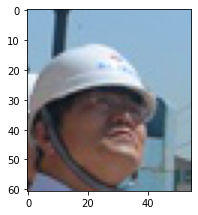

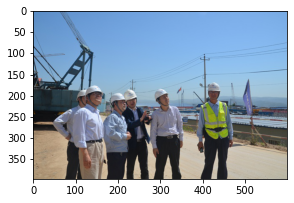

In [13]:
explore("01319.jpg")

# Load images in directories to train CNN

## creating the directory for training of CNN

In [14]:
#create a folder to save images in the drive
!mkdir "/content/Helmet_Dataset"
os.chdir("/content")
os.getcwd()

'/content'

##image scraping function

In [15]:
def isfloat(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [16]:
#indexing for image names
image_index = 1 

#function to save helmet dataset images
def SaveImages(imgdata):
  try:
    image = plt.imread("/content/train/helmet_dataset/JPEGImages/" + imgdata["ID"])
  except BaseException as b:
    print("error: " + b.strerror)
    return(0)
  for index in range(1,imgdata.shape[0],5):
    if(imgdata.iloc[index] is not None):
      if(isfloat(imgdata.iloc[index])):
        x = int(imgdata.iloc[index]) 
        y = int(imgdata.iloc[index+1]) 
        xh = int(imgdata.iloc[index+2])
        yh = int(imgdata.iloc[index+3])
        helmet_class = str(imgdata.iloc[index+4])
        image_path = os.path.join("/content/Helmet_Dataset/", helmet_class)
        crop_image = image[y:yh,x:xh]
        if(not (os.path.isdir(image_path))):
          os.mkdir(image_path) 
        os.chdir(image_path)
        global image_index
        image_index = image_index + 1
        image_name = helmet_class + "_" + str(image_index) + ".jpg"
        crop_image = cv2.cvtColor(crop_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(image_name,crop_image)        
    else:
      print("image scraping completed")
      os.chdir("/content/")
      return(0)

In [17]:
sample_target = target
print(sample_target)

             ID    0     1     2     3  ...  2100  2101  2102  2103  2104
0     01319.jpg  101   185   127   225  ...  None  None  None  None  None
1     00797.jpg  148    92   175   124  ...  None  None  None  None  None
2     00892.jpg  355   241   421   323  ...  None  None  None  None  None
3     00537.jpg  350    22   449   158  ...  None  None  None  None  None
4     01122.jpg   92    71   194   179  ...  None  None  None  None  None
...         ...  ...   ...   ...   ...  ...   ...   ...   ...   ...   ...
3169  00482.jpg   37   150    70   180  ...  None  None  None  None  None
3170  00762.jpg  942  1149  1069  1292  ...  None  None  None  None  None
3171  01126.jpg  196   150   234   206  ...  None  None  None  None  None
3172   1511.jpg  133  1863   273  2030  ...  None  None  None  None  None
3173  02304.jpg  188   201   210   225  ...  None  None  None  None  None

[3174 rows x 2106 columns]


## Scraping images

In [18]:
for imgdata in range(sample_target.shape[0]):
  SaveImages(sample_target.iloc[imgdata])

image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
error: No such file or directory
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
image scraping completed
error: No such file or directory
image scraping completed
image scraping completed
image scraping completed
image scr

In [ ]:
# #!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# import shutil

# dir_path = '/content/Helmet_Dataset/.....'

# try:
#     shutil.rmtree(dir_path)
# except OSError as e:
#     print("Error: %s : %s" % (dir_path, e.strerror))
# #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!1

# Train the CNN model with resnet (Transfer Learning)

##Directory to train cnn

In [19]:
data_dir = pathlib.Path("/content/Helmet_Dataset")
print(data_dir)

/content/Helmet_Dataset


##Initialising Batch size, image width , image height variables

In [20]:
batch_size = 32
img_height = 128
img_width = 128

##Creating train and test image dataset

In [21]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16483 files belonging to 5 classes.
Using 13187 files for training.


In [22]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16483 files belonging to 5 classes.
Using 3296 files for validation.


##Class names

In [24]:
class_names = train_ds.class_names
print(class_names)

['blue', 'none', 'red', 'white', 'yellow']


##Exploring random images from dataset created for training

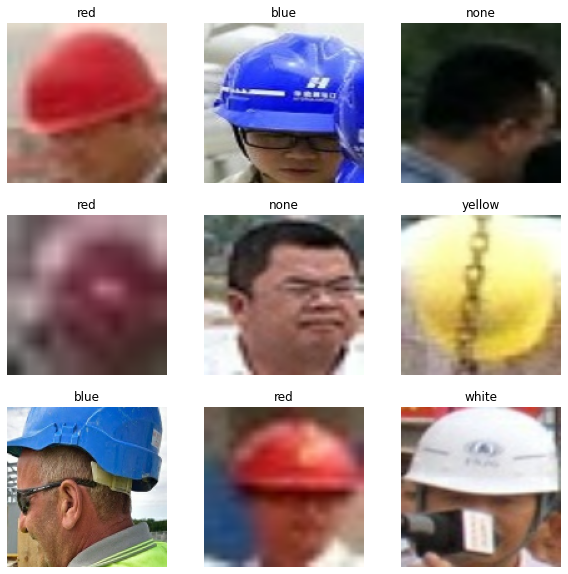

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

##checking for batches

In [26]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


##autotuning the datasets

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Normalising the datasets

In [28]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.043367036 0.9985844


##Data argumantation on datasets

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

##Data Argumantation results

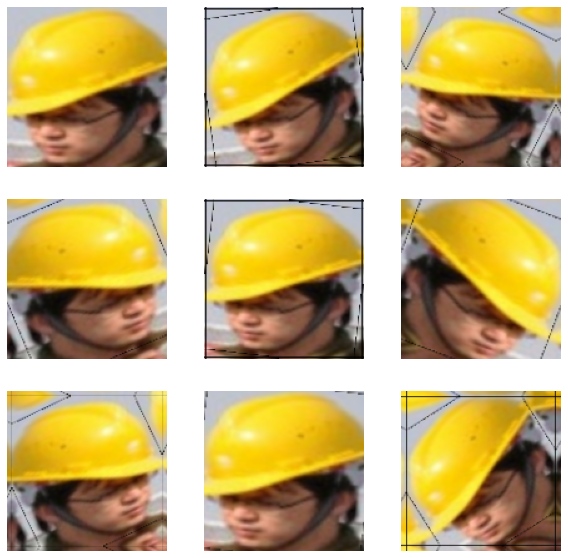

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[6].numpy().astype("uint8"))
    plt.axis("off")

##Resnet model 

In [32]:
restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height,img_width,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output)
for layer in restnet.layers:
    layer.trainable = False
restnet.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
______________________

##Transfer learning model with resnet

In [33]:
# model = Sequential([
#   data_augmentation,
#   #layers.experimental.preprocessing.Rescaling(1./255),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.Conv2D(128, 4, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.BatchNormalization(),
#   layers.Dropout(0.4),
#   layers.Conv2D(64, 4, padding='same', activation='relu'),
#   layers.Conv2D(32, 4, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.BatchNormalization(),
#   layers.Flatten(),
#   layers.Dense(470, activation='relu'),
#   layers.Dropout(0.3),
#   layers.Dense(235, activation='relu'),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

num_classes = 5

model = Sequential()
model.add(data_augmentation)
model.add(restnet)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='relu'))

##compile the model

In [34]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
functional_1 (Functional)    (None, 32768)             23587712  
_________________________________________________________________
dense (Dense)                (None, 512)               16777728  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                

##fitting the model

In [35]:
epochs = 4
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,workers=128
)

Epoch 1/4
413/413 [==============================] - 51s 124ms/step - loss: 0.9846 - accuracy: 0.6142 - val_loss: 0.3540 - val_accuracy: 0.8874
Epoch 2/4
413/413 [==============================] - 49s 120ms/step - loss: 0.4408 - accuracy: 0.8635 - val_loss: 0.2983 - val_accuracy: 0.9084
Epoch 3/4
413/413 [==============================] - 49s 120ms/step - loss: 0.3575 - accuracy: 0.8934 - val_loss: 0.2901 - val_accuracy: 0.9114
Epoch 4/4
413/413 [==============================] - 49s 120ms/step - loss: 0.3129 - accuracy: 0.9043 - val_loss: 0.2699 - val_accuracy: 0.9245


##Traning and validation accuracy metrics

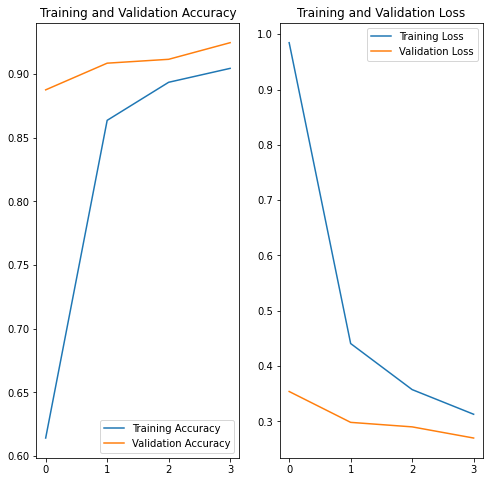

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##testing the model

In [37]:
#testing
sunflower_url = "https://contentgrid.homedepot-static.com/hdus/en_US/DTCCOMNEW/fetch/FetchRules/Rich_Content/305419402-non-vented-hard-hats-full-brim-hard-hats-cap-style-hard-hats-hard-hats-with-lights-11-2019.jpg"
sunflower_path = tf.keras.utils.get_file('white', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

147456/147351 [==============================] - 1s 3us/step
This image most likely belongs to white with a 99.59 percent confidence.


# Object detection


##Initialising confidence and threshold variables

In [38]:
confidence = 0.999
threshold = 0.1

## initialise bounding box and final bounding box variables

In [39]:
bounding_boxes = []
final_bounded_boxes = []

##Non Maxima Suppression function

In [40]:
def non_maxima_suppression():
  global threshold
  global final_bounded_boxes
  final_bounded_boxes = np.array(final_bounded_boxes)
  print(final_bounded_boxes)
  pick=[]
  if len(final_bounded_boxes) == 0:
    print("NO bounding boxes present")

  x1 = final_bounded_boxes[:,0]
  y1 = final_bounded_boxes[:,1]
  x2 = final_bounded_boxes[:,2]
  y2 = final_bounded_boxes[:,3]
  confidence = final_bounded_boxes[:,4]
  print("x1,y1,x2,y2")
  print(x1,y1,x2,y2,confidence)
  print("x1,y1,x2,y2")
  area = (np.subtract(x2,x1) + 1) * (np.subtract(y2,y1) + 1)
  idxs = np.argsort(area)
  while len(idxs) > 0:
    last = len(idxs) - 1
    i = idxs[last]
    pick.append(i)
    print("i")
    print(i)
    print("i")
    print("#")
    print(x1[i])
    print(x1[idxs[:last]])
    print(idxs[:last])
    print("#")

    xx1 = np.maximum(x1[i], x1[idxs[:last]])
    yy1 = np.maximum(y1[i], y1[idxs[:last]])
    xx2 = np.minimum(x2[i], x2[idxs[:last]])
    yy2 = np.minimum(y2[i], y2[idxs[:last]])

    w = np.maximum(0, xx2 - xx1 + 1)
    h = np.maximum(0, yy2 - yy1 + 1)

    overlap = (w * h) / area[idxs[:last]]
   
    idxs = np.delete(idxs, np.concatenate(([last],np.where(overlap > threshold)[0])))
  return final_bounded_boxes[pick].astype("int")

##Generate and view bounding boxes function

In [41]:
def generate_bounding_box(minx,miny):
  #print(minx,miny)
  global bounding_boxes
  bounding_boxes = []
  for i in range(1,5,2):
    for j in range(1,5,2):
      bounding_boxes.append((minx*i,miny*j))
  
def view_bounding_boxes(image):
  temp_image = copy.copy(image) 
  image_wridth,image_height = image.shape[:2]
  #print(image_wridth,image_height)
  centers = [(25,25),(250,250),(475,475),(25,375),(375,25)]
  for x,y in centers:
    for box_width,box_height in bounding_boxes:
      #print(box_width,box_height)
      xmin = 0 if(x-(box_width//2) <= 0 ) else x-(box_width//2)  
      ymin = 0 if(y-(box_height//2) <= 0 ) else y-(box_height//2)
      xmax = image_wridth-1 if(x+(box_width//2) >= image_wridth-1 ) else x+(box_width//2)
      ymax = image_height-1 if(y+(box_height//2) >= image_height-1 ) else y+(box_height//2)
      color = list(np.random.random(size=3) * 256)
      temp_image = cv2.rectangle(temp_image, (xmin,ymin), (xmax,ymax), color , thickness=5)
  view_image(temp_image)

##Detect Object function 

In [42]:
def Detect_object(image , grid):
  temp_image = copy.copy(image)
  global final_bounded_boxes
  final_bounded_boxes = []
  image_wridth,image_height = image.shape[:2]
  #print(image_wridth,image_height)
  for x,y in grid:
    for box_width,box_height in bounding_boxes:
      #print(box_width,box_height)
      center_x = x+25
      center_y = y+25
      xmin = 0 if(center_x-(box_width//2) <= 0 ) else center_x-(box_width//2)  
      ymin = 0 if(center_y-(box_height//2) <= 0 ) else center_y-(box_height//2)
      xmax = image_wridth-1 if(center_x+(box_width//2) >= image_wridth-1 ) else center_x+(box_width//2)
      ymax = image_height-1 if(center_y+(box_height//2) >= image_height-1 ) else center_y+(box_height//2)
      crop_image = temp_image[ymin:ymax,xmin:xmax]
      crop_image = cv2.resize(crop_image,(img_width,img_height))
      crop_image = tf.expand_dims(crop_image, 0) # Create a batch
      predictions = model.predict(crop_image)
      score = tf.nn.softmax(predictions[0])
      if (np.max(score) >= confidence and class_names[np.argmax(score)] != "none"):
        print(np.max(score),confidence,np.max(score) >= confidence)
        final_bounded_boxes.append([xmin,ymin,xmax,ymax,100 * np.max(score)])#class_names[np.argmax(score)]
  for final_box in final_bounded_boxes:
    color = list(np.random.random(size=3) * 256)
    temp_image = cv2.rectangle(temp_image, (final_box[0],final_box[1]), (final_box[2],final_box[3]), color , thickness=5)       
  view_image(temp_image)

## View Image functions

In [43]:
def view_image(image):
  plt.figure(figsize=(5, 5))
  plt.imshow(image)

def view_image_with_grid(image,grid):
  grid = np.array(grid , dtype=int)
  plt.figure(figsize=(5, 5))
  plt.imshow(image)
  plt.scatter(grid[:, 0], grid[:, 1], marker='.', color="red", s=100)
  plt.show()

def view_image_with_grid_centers(image,grid):
  grid = np.array(grid , dtype=int)
  plt.figure(figsize=(5, 5))
  plt.imshow(image)
  plt.scatter(grid[:, 0]+25, grid[:, 1]+25, marker='.', color="green", s=100)
  plt.show()
  

##Custom object detection function (Entry point for Object detection)

In [44]:
def Custom_Object_Detection(image_id):
  image = plt.imread("/content/train/helmet_dataset/JPEGImages/"+ image_id)
  image = cv2.resize(image,(500,500))
  image_wridth,image_height = image.shape[:2]
  grid = []
  x,y = (0,0)
  wh = image_wridth/10
  for i in range(0,500,50):
    for j in range(0,500,50):
      grid.append([i,j])
  view_image(image)
  view_image_with_grid(image,grid)
  view_image_with_grid_centers(image,grid)
  generate_bounding_box(int(wh),int(wh))
  view_bounding_boxes(image)
  Detect_object(image,grid)
  picked = non_maxima_suppression()
  print(picked)
  for pick in picked:
    box = pick
    color = list(np.random.random(size=3) * 256)
    temp_image = cv2.rectangle(image, (box[0],box[1]), (box[2],box[3]), color , thickness=5)       
  view_image(temp_image)

##detecting safety helmet in image

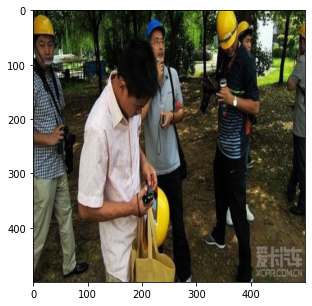

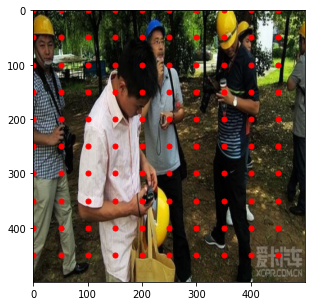

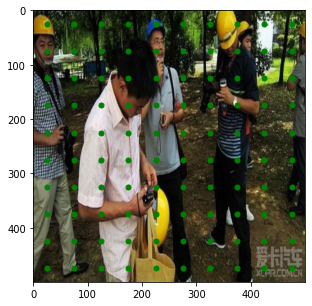

0.9998679 0.999 True
0.9990972 0.999 True
0.9999956 0.999 True
0.9999826 0.999 True
0.9999969 0.999 True
0.99919647 0.999 True
0.9999865 0.999 True
0.99997723 0.999 True
0.9999931 0.999 True
0.99998355 0.999 True
0.9995485 0.999 True
0.9999809 0.999 True
0.99951446 0.999 True
0.9995813 0.999 True
0.9997211 0.999 True
0.9999924 0.999 True
[[  0.           0.          50.          50.          99.98679161]
 [ 50.         100.         100.         150.          99.90972281]
 [200.         400.         250.         450.          99.99955893]
 [150.         400.         300.         450.          99.99825954]
 [150.         350.         300.         499.          99.99969006]
 [200.         350.         350.         499.          99.91964698]
 [250.           0.         400.          50.          99.99865294]
 [250.           0.         400.         100.          99.9977231 ]
 [350.           0.         400.          50.          99.99930859]
 [350.           0.         400.         100.   

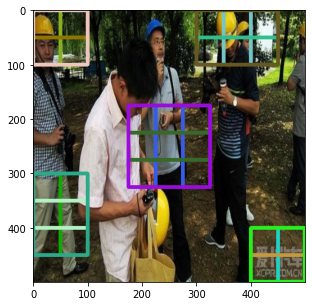

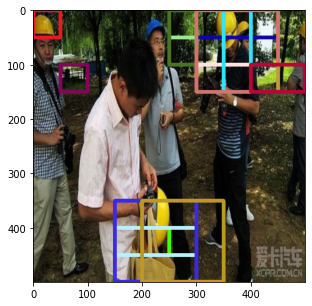

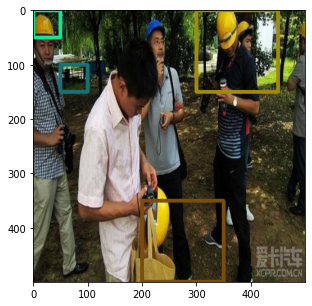

In [45]:
Custom_Object_Detection("00012.jpg")